## Low-Rank Autoregressive Tensor Completion Imputer (LATC-imputer)

This notebook shows how to implement a LATC (with truncated nuclear norm) imputer on three real-world data sets (i.e., PeMS traffic speed data, Guangzhou traffic speed data, Electricity data). To overcome the problem of missing values within multivariate time series data, this method takes into account both low-rank structure and time series regression. For an in-depth discussion of LATC-imputer, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Jinming Yang, Lijun Sun (2020). <b>Low-Rank Autorgressive Tensor Completion for Multivariate Time Series Forecasting</b>. arXiv:2006.10436. <a href="https://arxiv.org/abs/2006.10436" title="PDF"><b>[PDF]</b></a> 
</font>
</div>


In [2]:
import numpy as np
from numpy.linalg import inv as inv

### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT).</font></li>
</ul>
</div>

In [3]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [4]:
def svt_tnn(mat, tau, theta):
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[: theta] = 1
        mid[theta : idx] = (s[theta : idx] - tau) / s[theta : idx]
        return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ mat)
    elif m > 2 * n:
        return svt_tnn(mat.T, tau, theta).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    vec = s[: idx].copy()
    vec[theta : idx] = s[theta : idx] - tau
    return u[:, : idx] @ np.diag(vec) @ v[: idx, :]

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}} \times 100, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [10]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `imputer` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensors' nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate for ADMM, e.g., <code>rho = 0.0005</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code>. If <code>lambda0 = 0</code>, then this imputer is actually a standard low-rank tensor completion (i.e., High-accuracy Low-Rank Tensor Completion, or HaLRTC).</font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 50</code>. </font></li>
</ul>
</div>


In [60]:
dim = X.shape
dim_time = np.int(np.prod(dim) / dim[0])

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1500271973.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


There are 214 sensors!

In [80]:
DIR= '/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/'

tensor = scipy.io.loadmat(f'{DIR}/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat(f'{DIR}random_tensor.mat')
random_tensor = random_tensor['random_tensor']

# tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
# dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat(f'{DIR}random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.2
print(dense_tensor.shape)
print(random_matrix.shape)
dense_tensor = dense_tensor[:,:-1,:]
random_matrix = random_matrix[:,:-1]
print(dense_tensor.shape)
print(random_matrix.shape)
### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])
print(dense_tensor.shape)
del tensor, random_matrix, binary_tensor

(214, 61, 144)
(214, 61)
(214, 60, 144)
(214, 60)
(214, 144, 60)


In [164]:
import matplotlib.pyplot as plt
import time

In [243]:
print(dense_tensor.shape)
dense_tensor[0,2,:]

(214, 60, 144)


array([42.68 , 41.52 , 42.068, 42.665, 44.482, 45.433, 43.585, 45.227,
       47.927, 45.832, 47.063, 44.459, 46.55 , 43.816, 42.469, 42.065,
       43.303, 47.087, 45.978, 47.041, 42.831, 43.128, 46.854, 46.36 ,
       44.715, 45.675, 45.291, 47.735, 44.265, 46.103, 44.732, 42.323,
       43.116, 42.845, 42.422, 40.388, 41.404, 44.251, 45.21 , 43.168,
       42.652, 42.181, 41.833, 41.621, 40.533, 38.396, 39.166, 39.573,
       39.011, 37.056, 36.583, 37.345, 37.424, 37.536, 38.304, 36.406,
       37.007, 37.823, 36.244, 33.916, 31.122, 33.811, 35.374, 34.215,
       36.751, 37.087, 35.365, 36.876, 37.763, 38.09 , 38.046, 38.185,
       40.993, 41.003, 40.459, 40.827, 40.326, 38.3  , 40.181, 38.924,
       37.22 , 39.543, 39.579, 40.107, 39.211, 36.076, 35.321, 36.517,
       36.518, 35.012, 36.04 , 36.665, 35.978, 35.582, 34.712, 35.13 ,
       33.637, 31.849, 28.616, 22.554, 19.234, 20.95 , 19.852, 24.87 ,
       28.843, 31.602, 30.344, 23.422, 18.498, 20.28 , 18.413, 13.34 ,
      

In [238]:
X = np.zeros((214,30,288))
for i in range(30):
    X[:,i,:] = np.concatenate([dense_tensor[:,2*i,:],dense_tensor[:,(2*i)+1,:]],1)


In [247]:
X.shape

(214, 30, 288)

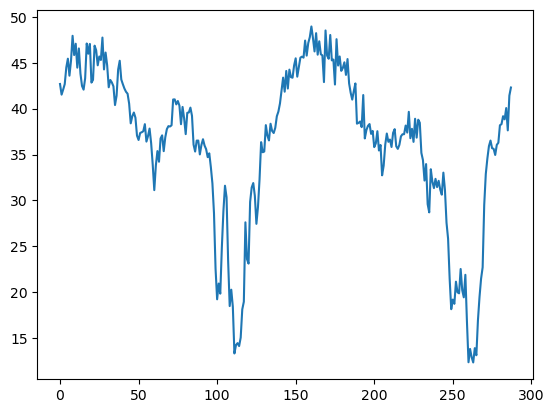

In [230]:
plt.plot(np.array(list(dense_tensor[0,2,:])+list(dense_tensor[0,3,:])))

In [212]:
ten2mat(dense_tensor, 0)

array([[40.893, 41.227, 42.68 , ..., 42.056, 42.006, 36.771],
       [50.319, 50.503, 47.984, ..., 48.565, 53.94 , 47.861],
       [53.88 , 57.001, 49.905, ..., 57.342, 57.069, 49.73 ],
       ...,
       [39.396, 37.812, 42.504, ..., 34.763, 34.06 , 34.383],
       [36.245, 37.881, 37.267, ..., 39.101, 37.67 , 35.101],
       [51.88 , 52.075, 51.066, ..., 50.982, 51.116, 51.566]])

In [197]:
DIR= '/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/'

tensor = scipy.io.loadmat(f'{DIR}/tensor.mat')
dense_tensor = tensor['tensor']
print(dense_tensor.shape)
dense_tensor = dense_tensor[:,:-1,:]
print(dense_tensor.shape)
ten2mat(dense_tensor, 1).shape
x = mat2ten(ten2mat(dense_tensor, 0),np.array([214,288,30]),0)
print(x.shape)
np.transpose(x, [0, 2, 1])[0,0,:].shape

(214, 61, 144)
(214, 60, 144)
(214, 288, 30)


(288,)

In [54]:
mat2ten(ten2mat(dense_tensor, 2),np.array([61,288,107]),0)[0,:,0]

array([40.893, 50.319, 53.88 , 37.305, 38.388, 49.13 , 35.466, 57.445,
       39.697, 48.646, 50.983, 42.27 , 45.276, 48.706, 10.621, 38.202,
       50.492, 35.824, 49.225, 49.294, 39.855, 44.002, 38.834, 41.276,
       37.452, 46.714, 42.157, 45.234, 45.205, 37.552, 40.196, 42.26 ,
       38.455, 37.342, 42.787, 45.891, 54.963, 39.511, 50.104, 54.054,
       41.171, 38.03 , 44.656, 46.199, 39.454, 43.059, 50.5  ,  0.   ,
       58.592, 52.294, 55.19 , 40.98 , 46.473, 56.108,  0.   , 54.37 ,
       55.528, 54.815, 21.31 , 47.025, 39.932, 56.976, 40.971, 52.685,
       51.172, 51.921, 42.832, 46.194, 39.936, 53.528, 36.016, 38.066,
       32.647, 46.696, 41.767, 34.754, 44.523, 54.133, 51.062, 54.523,
       43.042, 41.782, 35.69 , 46.103, 33.71 , 39.825, 39.749, 38.759,
       54.301, 33.997, 37.445, 41.561, 52.997, 51.035, 34.963, 46.772,
       48.505, 51.604, 44.552, 42.321, 36.326, 37.915, 43.006, 50.608,
       40.302, 39.952, 42.954, 56.402, 48.321, 41.941, 54.89 , 51.914,
      

In [12]:
import scipy.io
import time
DIR= '/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/'

tensor = scipy.io.loadmat(f'{DIR}/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat(f'{DIR}random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_tensor,binary_tensor


start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 30
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_62114/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.00100815
MAPE: 0.0627966
RMSE: 2.73245

Total iteration: 100
Tolerance: 0.00100815
Imputation MAPE: 0.0627966
Imputation RMSE: 2.73245

Running time: 101 seconds


In [250]:
random_tensor['random_tensor'].shape

(214, 61, 144)

In [263]:
import scipy.io
import time
DIR= '/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/'

tensor = scipy.io.loadmat(f'{DIR}/tensor.mat')
dense_tensor = tensor['tensor']
X = np.zeros((214,30,288))
for i in range(30):
    X[:,i,:] = np.concatenate([dense_tensor[:,2*i,:],dense_tensor[:,(2*i)+1,:]],1)
dense_tensor = X
random_tensor = scipy.io.loadmat(f'{DIR}random_tensor.mat')
random_tensor = np.reshape(random_tensor['random_tensor'][:,:-1,:], X.shape)

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_tensor,binary_tensor


start = time.time()
h = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
h = np.concatenate([h, h+144*np.ones(h.shape)])
time_lags = np.round(h).astype(int)
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 30
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_62114/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.000849774
MAPE: 0.0607753
RMSE: 2.66397

Total iteration: 100
Tolerance: 0.000849774
Imputation MAPE: 0.0607753
Imputation RMSE: 2.66397

Running time: 224 seconds


In [283]:
doc = np.concatenate([np.ones(4740), np.zeros(253418-4740)])
col = np.concatenate([np.ones(71742), np.zeros(253418-71742)])
sd = doc.std()
sc = col.std()

In [291]:
(1- col.mean())/sc

1.591336557504968

In [293]:
(1/4 - doc.mean())/sd

1.7072503518350028

In [276]:
((1/2) - (4740/253418))/np.concatenate([np.ones(4740), np.zeros(253418-4740)]).std() - ((1/4) - (4740/253418))/np.concatenate([np.ones(4740), np.zeros(253418)]).std()

1.829720161233386

In [254]:
dense_tensor.shape

(214, 61, 144)

In [189]:
dim = dense_tensor.shape
dim = (np.prod(dim) / dim[0])
dim

8640.0

In [ ]:
ten2mat()

In [5]:
def imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, theta, epsilon, maxiter):
    """Low-Rank Autoregressive Tensor Completion, LATC-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = np.int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    X = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{X}}
    T = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    A = 0.001 * np.random.rand(dim[0], d)     # \boldsymbol{A}
    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    while True:
        rho = min(rho*1.05, 1e5)
        for k in range(len(dim)):
            X[k] = mat2ten(svt_tnn(ten2mat(mat2ten(Z, dim, 0) - T[k] / rho, k), alpha[k] / rho, theta), dim, k)
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        mat_hat = ten2mat(tensor_hat, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        if lambda0 > 0:
            for m in range(dim[0]):
                Qm = mat_hat[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                mat0[m, :] = Qm @ A[m, :]
            mat1 = ten2mat(np.mean(rho * X + T, axis = 0), 0)
            Z[pos_missing] = np.append((mat1[:, : max_lag] / rho), (mat1[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = (ten2mat(np.mean(X + T / rho, axis = 0), 0))[pos_missing]
        T = T + rho * (X - np.broadcast_to(mat2ten(Z, dim, 0), np.insert(dim, 0, len(dim))))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 100 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    print()
    
    return tensor_hat

### Guangzhou data

We generate **random missing (RM)** values on Guangzhou traffic speed data set.

In [104]:
import scipy.io
DIR= '/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/'
tensor = scipy.io.loadmat(f'{DIR}tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('/Users/zoeshleifer/tensor-learning/datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_tensor,binary_tensor

We use `imputer` to fill in the missing entries and measure performance metrics on the ground truth.

In [57]:
sparse_tensor.shape

(214, 144, 61)

In [295]:
import pickle
import pandas as pd

In [84]:
X1.loc[X2.index]

,chlorophyll,turbidity,QSE,air_temperature,wind_gust,wind_min,wind_speed,wind_gust_1s,wind_direction,wind_percent_good
index,,,,,,,,,,
0,1.232000e+00,0.8035,0.270300,10.710,6.542,1.55,4.087,6.92,268.90,1.0
1,1.018000e+00,0.7620,0.193800,10.940,5.290,1.05,3.401,5.53,284.60,1.0
2,1.103000e+00,0.7370,0.316200,11.370,4.048,0.94,2.355,4.19,252.40,1.0
3,1.259000e+00,0.8550,0.387600,11.060,6.488,1.60,4.384,6.78,200.30,1.0
4,1.319000e+00,0.6840,0.316200,11.370,5.756,1.83,4.021,6.14,222.30,1.0
...,...,...,...,...,...,...,...,...,...,...
19450,1.999999e-03,16.7725,12.180799,-1.427,5.212,2.53,4.117,5.47,21.85,1.0
19451,2.999999e-03,16.5850,10.773200,-1.271,3.908,1.89,2.854,4.05,4.61,1.0
19452,9.999988e-04,16.0505,10.883600,-1.143,5.536,2.52,4.180,5.78,14.26,1.0


In [122]:
X = np.array([X1.values, X2.values])
s = X.shape

In [123]:
s

(2, 19147, 10)

In [179]:
missing_rate = .2
np.random_seed=5
X_nulled = np.multiply(X,np.round(np.random.random(s)+(.5-missing_rate)))

In [180]:
pd.DataFrame(X_nulled[0]).interpolate(method='index').values

array([[ 1.232000e+00,  8.035000e-01,  0.000000e+00, ...,  6.920000e+00,
         2.689000e+02,  1.000000e+00],
       [ 1.018000e+00,  0.000000e+00,  1.938000e-01, ...,  5.530000e+00,
         2.846000e+02,  1.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  3.162000e-01, ...,  4.190000e+00,
         2.524000e+02,  1.000000e+00],
       ...,
       [ 9.999988e-04,  1.605050e+01,  1.088360e+01, ...,  5.780000e+00,
         1.426000e+01,  1.000000e+00],
       [-1.192093e-09,  1.667550e+01,  1.093880e+01, ...,  5.200000e+00,
         1.565000e+01,  1.000000e+00],
       [ 1.900000e-02,  1.618050e+01,  1.121480e+01, ...,  5.260000e+00,
         2.164000e+01,  0.000000e+00]])

In [181]:
compute_rmse(X1.values,pd.DataFrame(X_nulled[0]).interpolate(method='index').values)

106.48430417518547

In [296]:
file = open('final_X.pkl','rb')
X_final = pickle.load(file)
Xdf = X_final.fillna(0)

In [301]:
Xdf.columns

Index(['J04_optics_all', 'UNH_CML_realtime', 'UNH_CO2_realtime', 'UNH_GBB',
       'LOBO_CSV_66', 'LOBO_CSV_65', 'LOBO_CSV_64', 'LOBO_CSV_67',
       'LOBO_CSV_70', 'LOBO_CSV_72', 'D03_optics_all', 'C05_optics_all',
       'A01_optics_s_all', 'URI_169-QP_SurfaceSonde', 'URI_CPoint_BottomSonde',
       'URI_CPoint_SurfaceSonde', 'URI_GBay_BottomSonde',
       'URI_GBay_SurfaceSonde', 'URI_NP_BottomSonde', 'URI_NP_SurfaceSonde',
       'URI_PP_BottomSonde', 'URI_PP_SurfaceSonde'],
      dtype='object')

In [299]:
Xdf['A01_optics_s_all']

5310    3.337654
5311    6.480881
5312    5.800389
5313    7.841867
5314    4.633830
          ...   
8028    0.896101
8029    0.871882
8030    0.871882
8031    0.847663
8032    0.799225
Name: A01_optics_s_all, Length: 2723, dtype: float64

In [377]:
X = mat2ten(Xdf.values,np.array((389,22,7)),2)
import random
import time
from tqdm import tqdm
random.seed(10)
k = 30
X_dense = mat2ten(Xdf.values,np.array((389,22,7)),2)
rhos = [10e-1, 10e-2,5*10e-3,2*10e-3, 10e-3, 10e-4, 10e-5]
res = {r:list() for r in rhos}
for i in tqdm(range(len(rhos))):
    rho=rhos[i]
    for j in range(5):
        random.seed(j*10)
        nulled = Xdf.copy()
        s = random.sample(list(Xdf.index), k)
        testers = nulled['A01_optics_s_all'].loc[s].loc[nulled['A01_optics_s_all'].loc[s] != 0]
        nulled['A01_optics_s_all'].loc[s] = np.zeros(k)
        X_sparse = mat2ten(nulled.values,np.array((389,22,7)),2)

        start = time.time()
        time_lags = np.array([1, 2, 3, 4, 5, 6,100,101,102,103,104,105])
        alpha,rho,lambda0,theta,epsilon,maxiter = [np.ones(3) / 3,rho,.1*rho,1,1e-4,100]
        tensor_hat = imputer(X.copy(), X, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
        X_hat = ten2mat(tensor_hat,1)
        end = time.time()

        print('Running time: %d seconds'%(end - start))
        hat = pd.DataFrame(X_hat.transpose(),columns=Xdf.columns, index=Xdf.index)
        res[rhos[i]].append(compute_mape(testers, hat['A01_optics_s_all'].loc[testers.index]))
        print(res)

  0%|                                                     | 0/7 [00:00<?, ?it/s]/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Total iteration: 93
Tolerance: 9.83576e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994], 0.1: [], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 93
Tolerance: 9.83576e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868], 0.1: [], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 93
Tolerance: 9.83576e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488], 0.1: [], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 93
Tolerance: 9.83576e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234], 0.1: [], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 93
Tolerance: 9.83576e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Total iteration: 91
Tolerance: 9.76691e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 91
Tolerance: 9.76691e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 91
Tolerance: 9.76691e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 91
Tolerance: 9.76691e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 91
Tolerance: 9.76691e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Total iteration: 95
Tolerance: 9.60703e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 95
Tolerance: 9.60703e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 95
Tolerance: 9.60703e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 95
Tolerance: 9.60703e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Total iteration: 95
Tolerance: 9.60703e-05
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.000116927
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.000116927
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.000116927
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.000116927
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.000116927
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.000116927
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.000116927
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.000116927
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 5 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.000116927
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.000116927
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 4 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.00016402
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00016402
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 4 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00016402
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00016402
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00016402
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00016402
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00016402
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00016402
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00016402
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00016402
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.00017462
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00017462
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00017462
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00017462
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00017462
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00017462
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 4 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758, 1.7509798577542268], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00017462
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00017462
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 4 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758, 1.7509798577542268, 1.3773883792705741], 0.0001: []}


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int

Iter: 100
Tolerance: 0.00017462
MAPE: nan
RMSE: nan

Total iteration: 100
Tolerance: 0.00017462
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 3 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758, 1.7509798577542268, 1.3773883792705741, 1.634965412969936], 0.0001: []}
Total iteration: 2
Tolerance: 0.0
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 0 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(var - var_hat) / var) / var.shape[0]
/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1501381063.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(np.sum((var - var_hat

Total iteration: 2
Tolerance: 0.0
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 0 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758, 1.7509798577542268, 1.3773883792705741, 1.634965412969936], 0.0001: [1.0, 1.0, 1.0]}
Total iteration: 2
Tolerance: 0.0
Imputation MAPE: nan
Imputation RMSE: nan

Running time: 0 seconds
{1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653

In [381]:
res = {1.0: [0.6591810860693994, 1.6648359820715868, 1.7621331777920488, 0.8689036056932234, 1.3473474436319692], 0.1: [0.662503859096653, 1.6681848339424703, 1.7545646966153792, 0.8952647828733504, 1.3639775566615426], 0.05: [0.6683754909803677, 1.6708342874275124, 1.753066097119554, 0.9159365487404842, 1.3807947822841273], 0.02: [0.6885068502456471, 1.6694401214204753, 1.7607046001617954, 0.9690455877611971, 1.4429426851662746], 0.01: [0.6981588422336835, 1.650438191722477, 1.7802504520475964, 1.039960456030213, 1.5332872734893093], 0.001: [0.6338858882267332, 1.587809502288758, 1.7509798577542268, 1.3773883792705741, 1.634965412969936], 0.0001: [1.0, 1.0, 1.0, 1.0, 1.0]}

In [382]:
res = pd.DataFrame(res).transpose()

In [393]:
res.mean(axis=1)

1.0000    1.260480
0.1000    1.268899
0.0500    1.277801
0.0200    1.306128
0.0100    1.340419
0.0010    1.397006
0.0001    1.000000
dtype: float64

NameError: name 'res' is not defined

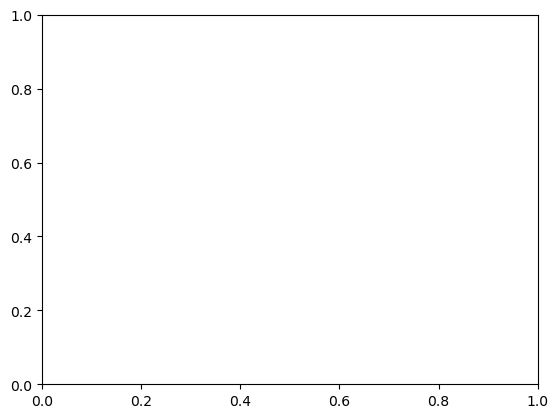

In [302]:
fig,ax = plt.subplots(1,1)
ax.scatter(res.index[:-1],res.mean(axis=1))
ax.set_xscale('log')

In [321]:
import matplotlib
font = {'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [307]:
res = np.array([[1.0000,    1.260480]
,[0.1000,    1.268899]
,[0.0500,    1.277801]
,[0.0200,    1.306128]
,[0.0100,    1.340419]
,[0.0010,    1.397006]])

Text(0, 0.5, 'RMSE')

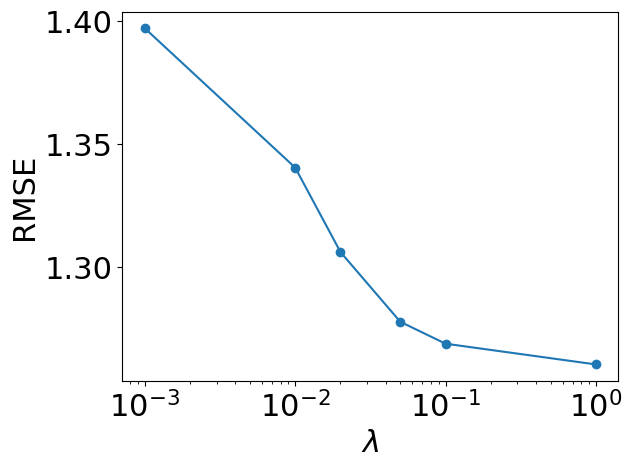

In [322]:
fig,ax = plt.subplots(1,1)
ax.plot(res[:,0], res[:,1],'-o')
ax.set_xscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('RMSE')

In [357]:
pd.DataFrame(X_hat.transpose(),columns=Xdf.columns, index=Xdf.index)

,J04_optics_all,UNH_CML_realtime,UNH_CO2_realtime,UNH_GBB,LOBO_CSV_66,LOBO_CSV_65,LOBO_CSV_64,LOBO_CSV_67,LOBO_CSV_70,LOBO_CSV_72,...,A01_optics_s_all,URI_169-QP_SurfaceSonde,URI_CPoint_BottomSonde,URI_CPoint_SurfaceSonde,URI_GBay_BottomSonde,URI_GBay_SurfaceSonde,URI_NP_BottomSonde,URI_NP_SurfaceSonde,URI_PP_BottomSonde,URI_PP_SurfaceSonde
5310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [415]:
for i in range(7):
    j = 339*i
    print(((Xdf.iloc[j:j+339] == 0).sum()<300).sum())

6
7
6
6
12
6
5


In [406]:
(Xdf == 0).sum()

J04_optics_all             2464
UNH_CML_realtime           2415
UNH_CO2_realtime           2445
UNH_GBB                    2530
LOBO_CSV_66                1596
LOBO_CSV_65                2056
LOBO_CSV_64                2610
LOBO_CSV_67                2592
LOBO_CSV_70                2420
LOBO_CSV_72                2569
D03_optics_all             2473
C05_optics_all             2443
A01_optics_s_all            746
URI_169-QP_SurfaceSonde    2037
URI_CPoint_BottomSonde     2521
URI_CPoint_SurfaceSonde    2494
URI_GBay_BottomSonde       2299
URI_GBay_SurfaceSonde      2512
URI_NP_BottomSonde         2473
URI_NP_SurfaceSonde        2659
URI_PP_BottomSonde         2592
URI_PP_SurfaceSonde        2591
dtype: int64

In [407]:
Xdf

,J04_optics_all,UNH_CML_realtime,UNH_CO2_realtime,UNH_GBB,LOBO_CSV_66,LOBO_CSV_65,LOBO_CSV_64,LOBO_CSV_67,LOBO_CSV_70,LOBO_CSV_72,...,A01_optics_s_all,URI_169-QP_SurfaceSonde,URI_CPoint_BottomSonde,URI_CPoint_SurfaceSonde,URI_GBay_BottomSonde,URI_GBay_SurfaceSonde,URI_NP_BottomSonde,URI_NP_SurfaceSonde,URI_PP_BottomSonde,URI_PP_SurfaceSonde
5310,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,3.337654,13.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5311,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,6.480881,9.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5312,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,5.800389,5.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5313,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,7.841867,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5314,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,4.633830,5.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8028,0.0,0.0,0.0,0.0,0.0,0.930,0.0,0.0,0.0,0.0,...,0.896101,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8029,0.0,0.0,0.0,0.0,0.0,1.010,0.0,0.0,0.0,0.0,...,0.871882,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8030,0.0,0.0,0.0,0.0,0.0,1.020,0.0,0.0,0.0,0.0,...,0.871882,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8031,0.0,0.0,0.0,0.0,0.0,0.945,0.0,0.0,0.0,0.0,...,0.847663,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7650     1.843163
5443     3.717884
7286     5.027250
7677     1.918566
5370    12.994167
6154     5.434783
7322     2.095789
6446     4.555029
7986     5.073868
5966    15.251964
5450     2.979293
7442     2.013212
7317     2.508671
5621     7.213466
6333     3.410658
5492     1.448958
5878     7.670576
7780     1.700737
6764     3.677949
6471     2.619800
6384     4.766586
6025     1.237923
Name: A01_optics_s_all, dtype: float64

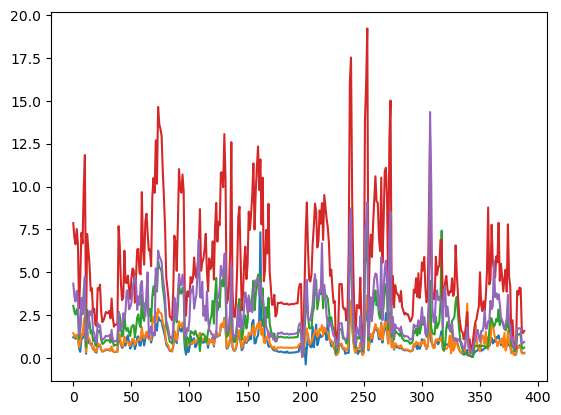

In [265]:
import matplotlib.pyplot as plt
plt.plot(tensor_hat[:,:5,0])

In [10]:
tensor_hat.shape

(214, 144, 61)

In [183]:
import scipy.io

tensor = scipy.io.loadmat(f'{DIR}tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat(f'{DIR}random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.7

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_tensor,binary_tensor

In [184]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 30
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


KeyboardInterrupt: 

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_62114/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Iter: 100
Tolerance: 0.000383623


NameError: name 'compute_mape' is not defined

We generate **non-random missing (NM)** values on Guangzhou traffic speed data set. Then, we conduct the imputation experiment.

In [199]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.7

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[2]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_matrix, binary_tensor

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Guangzhou-data-set/tensor.mat'

<function ndarray.transpose>

In [205]:
random_matrix[1,10]

IndexError: index 10 is out of bounds for axis 1 with size 10

In [209]:
np.random_seed = 5


In [226]:

missing_rate = .2
np.random_seed=123
r = np.zeros(X.shape)
random_matrix = np.random.random((X.shape[0],X.shape[2]))
for i1 in range(X.shape[0]):
    for i2 in range(X.shape[2]):
        r[i1, :,i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
X_nulled= np.multiply(X, r)


print(compute_rmse(X1.values,pd.DataFrame(X_nulled[0]).interpolate(method='index').values))

tensor_hat = imputer(X, X_nulled, time_lags, alpha, rho, 0, theta, epsilon, maxiter)

import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6,100,500])
alpha,rho,lambda0,theta,epsilon,maxiter = [np.ones(3) / 3,10e-4,.1*rho,1,1e-4,100]
tensor_hat = imputer(X, X_nulled, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

16.83823314339589


/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_78613/1323771951.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


Total iteration: 53
Tolerance: 9.96659e-05
Imputation MAPE: 8.5285
Imputation RMSE: 102.829

Total iteration: 45
Tolerance: 9.67012e-05
Imputation MAPE: 1.39814
Imputation RMSE: 107.243

Running time: 4 seconds


In [6]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.4

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_matrix, binary_tensor

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Guangzhou-data-set/tensor.mat'

In [15]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
theta = 10
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Tolerance: 0.000349004
MAPE: 0.095094
RMSE: 4.07247

Total iteration: 100
Tolerance: 0.000349004
Imputation MAPE: 0.095094
Imputation RMSE: 4.07247

Running time: 108 seconds


In [16]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.6

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

del tensor, random_matrix, binary_tensor

In [17]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
theta = 10
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 98
Tolerance: 9.94529e-05
Imputation MAPE: 0.0992054
Imputation RMSE: 4.24785

Running time: 107 seconds


### PeMS data

In [18]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [19]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 15
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Tolerance: 0.000166927
MAPE: 0.0296809
RMSE: 2.14096

Total iteration: 100
Tolerance: 0.000166927
Imputation MAPE: 0.0296809
Imputation RMSE: 2.14096

Running time: 182 seconds


In [20]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [21]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 15
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 97
Tolerance: 9.29503e-05
Imputation MAPE: 0.0350057
Imputation RMSE: 2.5372

Running time: 183 seconds


In [22]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.6

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [23]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
theta = 15
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 88
Tolerance: 7.15694e-05
Imputation MAPE: 0.0432256
Imputation RMSE: 3.1274

Running time: 174 seconds


In [24]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_matrix = np.load('../datasets/PeMS-data-set/random_matrix.npy')

missing_rate = 0.2

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 288, 44))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(44):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

In [25]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
theta = 10
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 86
Tolerance: 8.91413e-05
Imputation MAPE: 0.073069
Imputation RMSE: 5.14883

Running time: 156 seconds


In [26]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_matrix = np.load('../datasets/PeMS-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 288, 44))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(44):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

In [27]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
theta = 10
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 77
Tolerance: 7.96771e-05
Imputation MAPE: 0.0778101
Imputation RMSE: 5.46434

Running time: 136 seconds


In [28]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_matrix = np.load('../datasets/PeMS-data-set/random_matrix.npy')

missing_rate = 0.6

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 288, 44))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(44):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

In [29]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
theta = 10
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 78
Tolerance: 9.73289e-05
Imputation MAPE: 0.0862884
Imputation RMSE: 5.97921

Running time: 129 seconds


### Electricity data

- **Random Missing (RM)**:

In [30]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_tensor = np.load('../datasets/Electricity-data-set/random_tensor.npy')

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [31]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 65
Tolerance: 9.86947e-05
Imputation MAPE: 0.0979778
Imputation RMSE: 529.818

Running time: 11 seconds


In [32]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_tensor = np.load('../datasets/Electricity-data-set/random_tensor.npy')

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [33]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 70
Tolerance: 9.60873e-05
Imputation MAPE: 0.106765
Imputation RMSE: 733.626

Running time: 12 seconds


In [34]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_tensor = np.load('../datasets/Electricity-data-set/random_tensor.npy')

missing_rate = 0.6

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_tensor, binary_tensor

In [35]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 77
Tolerance: 9.81571e-05
Imputation MAPE: 0.124384
Imputation RMSE: 823.718

Running time: 12 seconds


- **Nonrandom Missing (NM)**:

In [36]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_matrix = np.load('../datasets/Electricity-data-set/random_matrix.npy')

missing_rate = 0.2

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 24, 35))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(35):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

In [37]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 67
Tolerance: 9.16245e-05
Imputation MAPE: 0.165755
Imputation RMSE: 652.177

Running time: 10 seconds


In [38]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_matrix = np.load('../datasets/Electricity-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 24, 35))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(35):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

In [39]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 76
Tolerance: 9.65526e-05
Imputation MAPE: 0.154994
Imputation RMSE: 1026.03

Running time: 12 seconds


In [1]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_matrix = np.load('../datasets/Electricity-data-set/random_matrix.npy')

missing_rate = 0.6

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 24, 35))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(35):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

del dense_mat, random_matrix, binary_tensor

NameError: name 'np' is not defined

In [41]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
theta = 1
epsilon = 1e-4
maxiter = 100
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Tolerance: 0.000486948
MAPE: 0.170339
RMSE: 3514.81

Total iteration: 100
Tolerance: 0.000486948
Imputation MAPE: 0.170339
Imputation RMSE: 3514.81

Running time: 16 seconds


In [4]:
ys.shape

(4000, 2)

In [5]:
import numpy as np
np.random.normal(size=(10,5))

array([[-0.28441689, -0.39755546,  0.7791499 , -1.47905634,  0.32195403],
       [ 0.34529065, -1.16859334,  0.26769084,  0.5545709 ,  1.21340986],
       [-0.0488086 , -1.14828142,  0.22287038,  1.33428377, -1.61020854],
       [-1.06358787,  0.48486928,  0.05289515, -2.19737312,  1.13775931],
       [-0.95637732,  0.90740697, -2.65038704,  1.39618396,  0.60128418],
       [ 2.13809597, -0.39683194,  0.31697589, -0.66890644,  0.19677426],
       [ 0.02447134, -2.32913903, -0.71533849, -0.29758715,  1.47756378],
       [ 0.46273214,  0.78264201, -0.62078796,  0.94368631,  1.33568035],
       [-2.52726986,  0.22340297,  0.96389869,  0.14029278,  0.20956225],
       [ 1.02999454, -0.26099978,  0.13365325,  1.98057996, -0.38199202]])

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

coeffs = np.random.random(size=(10,5))
coeffs1 = coeffs[:,:5]
coeffs2 = coeffs[:,5:]
def equation(Y, t):
    y,dydt = Y(t-5)
    ydelay, dydt_delay =Y(t-5)[0], Y(t-5)[1]
    return [dydt, -dydt - (2 * coeffs1@y) - (0.5 * coeffs2@ydelay)]

def initial_history_func(t):
    return np.random.normal(size=(5))

plt.rcParams['font.size'] = 8
fig, axs = plt.subplots(1, 1)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle("$y''(t)=-y'(t) - 2 y(t) - 0.5 y(t-1)$ solved by ddeint")

ts = np.linspace(0, 16, 4000)

ys = ddeint(equation, initial_history_func, ts)

axs.plot(ts, ys[:,0], color='red', linewidth=1)
axs.plot(ts, ys[:,1], color='green', linewidth=1)
axs.set_title('$ihf_y(t)=1; ihf_{dy/dt}(t)=0$')

plt.show()

Traceback (most recent call last):
capi_return is NULL
Call-back cb_f_in_dvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Users/zoeshleifer/miniconda3/lib/python3.10/site-packages/ddeint/ddeint.py", line 60, in f2
    return f(self.Y, t, *args)
  File "/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_62099/404143289.py", line 9, in equation
ValueError: too many values to unpack (expected 2)

Extension modules: zmq.backend.cython.context, zmq.backend.cython.message, zmq.backend.cython.socket, zmq.backend.cython._device, zmq.backend.cython._poll, zmq.backend.cython._proxy_steerable, zmq.backend.cython._version, zmq.backend.cython.error, zmq.backend.cython.utils, tornado.speedups, psutil._psutil_osx, psutil._psutil_posix, numpy.core._multiarray_umath, numpy.core._multiarray_tests, numpy.linalg._umath_linalg, numpy.fft._pocketfft_internal, numpy.rand

In [10]:
np.arange(0,2,.2).shape

(10,)

In [28]:
hist = np.arange(0,2,.2)+np.random.normal(10,scale = .1)
y = np.cos(hist.copy())
for i in range(10):
    y = np.append(y, y[-1]-5*(pow(y[-1]-y[-2],2))+[-8]+np.random.normal(scale = .2))

/var/folders/g6/dvksyd2x2vzgtx4pt5g71bzh0000gn/T/ipykernel_58776/2920577733.py:4: RuntimeWarning: overflow encountered in double_scalars
  y = np.append(y, y[-1]-5*(pow(y[-1]-y[-2],2))+[-8]+np.random.normal(scale = .2))


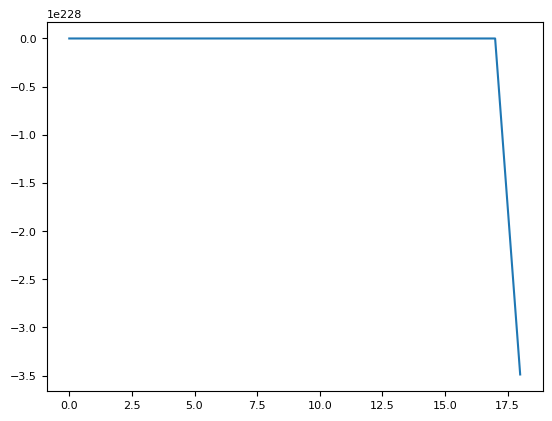

In [27]:
plt.plot(y)

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>